In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from db.db import read_table
from db.models import TableName

# Evaluation

Now that our model is trained and we have done end-to-end prediction with the CPP inference engine, it's time to do some evaluation of our failing predictions. During training, our validation showed a ~92% accuracy at top 1 rank for the standard model and ~77% for the complex. Both models showed ~95% accuracy at top 3.

Our test worked out 74% at top 1 and 94% at top3 using our combine standard and complex test set. From 22000 test values we got 1200 failing cases which the model was unable to rank the correct template in the top 3 candidates. Here we will explore what trends exist in that subset.

In [2]:
# Load data from SQL
lp_clean = read_table(TableName.LP_CLEAN)
firm_template_map = read_table(TableName.FIRM_TEMPLATE_MAP)
candidate_templates = read_table(TableName.CANDIDATE_TEMPLATES)

# Load failing ids pulled from integration tests
failed_ids = pd.read_csv("failed_ids.csv")["failed_ids"].to_list()

Read LP_CLEAN table from database!
Read FIRM_TEMPLATE_MAP table from database!
Read CANDIDATE_TEMPLATES table from database!


In [3]:
# Isolate failed rows
failed_rows = lp_clean[lp_clean["id"].isin(failed_ids)]
failed_rows.shape

(1248, 32)

First, we will do some basic viewing of categorical columns.

In [4]:
# Categorical distribution
print(failed_rows["firm"].value_counts().head(10))
print(failed_rows["country"].value_counts().head(10))
print(failed_rows["role"].value_counts().head(10))

firm
weil, gotshal & manges pension fund         282
sidley austin master pension trust          167
white & case llp master retirement trust     56
jones day defined benefit master trust       47
merrill lynch, pierce, fenner & smith        25
equitable advisors                           24
northrock partners                           18
artisan capital partners                     14
ameriprise financial services                14
j.p. morgan private bank                     12
Name: count, dtype: int64
country
us             959
canada          38
uk              31
france          20
netherlands     17
switzerland     14
malaysia        11
spain           10
belgium         10
china            9
Name: count, dtype: int64
role
investment team                         597
finance/accountancy                      93
portfolio management                     39
legal                                    33
operations                               29
finance/accountancy,investment team     

Looks like a few dominate, I believe those are large firms so that is to be expected. Aside from that the US and Investment team investors are by far the biggest offenders, they are also the largest country and job role featured in the dataset so that lines up.

In [5]:
# Boolean flags
bool_flags = [
    "has_german_char", "has_nfkd_normalized", "has_nickname",
    "has_multiple_first_names", "has_middle_name",
    "has_multiple_middle_names", "has_multiple_last_names",
    "is_shared_infra", "firm_is_multi_domain"
]

print(failed_rows[bool_flags].sum().sort_values(ascending=False))

firm_is_multi_domain         510
has_nickname                 414
is_shared_infra              287
has_multiple_last_names       93
has_nfkd_normalized           51
has_middle_name               47
has_multiple_first_names      14
has_german_char               11
has_multiple_middle_names      7
dtype: int64


Multi and shared domain infrastructure firms appear in our failed rows. Also nickname emails heavily skew our dataset, this is probably because our inference engine does not propose a predicted email for each of the nickname iterations in the nickname map. Instead it only uses one nickname per full name and tries to resolve with that. In other words, the correct template may be predicted correctly but the way we resolve the nickname in the CPP inference engine causes the prediction to fail (in inference, we validate a prediction during integration tests by doing a string comparison between the actual email and the email the engine resolve from the predicted template - whereas during validation we merely compare predicted templates).

In [6]:
# Get non failed ids
comp_ids = pd.read_csv("../../cpp_inference_engine/tests/test_data/test_comp_ids.csv")["test_ids"].to_list()
std_ids = pd.read_csv("../../cpp_inference_engine/tests/test_data/test_std_ids.csv")["test_ids"].to_list()
passed_ids = [x for x in comp_ids + std_ids if x not in failed_ids]

In [7]:
non_failed_rows = lp_clean[lp_clean["id"].isin(passed_ids)]

# Compare from passing distributions.
compare_flags = pd.DataFrame({
    "fail_pct": failed_rows[bool_flags].mean(),
    "non_fail_pct": non_failed_rows[bool_flags].mean()
}).sort_values("fail_pct", ascending=False)

compare_flags["difference"] = compare_flags["fail_pct"] - compare_flags["non_fail_pct"]
print(compare_flags)

                           fail_pct  non_fail_pct  difference
firm_is_multi_domain       0.408654      0.267852    0.140802
has_nickname               0.331731      0.241426    0.090304
is_shared_infra            0.229968      0.273583   -0.043615
has_multiple_last_names    0.074519      0.008915    0.065604
has_nfkd_normalized        0.040865      0.007778    0.033088
has_middle_name            0.037660      0.007869    0.029792
has_multiple_first_names   0.011218      0.004139    0.007079
has_german_char            0.008814      0.002593    0.006222
has_multiple_middle_names  0.005609      0.001001    0.004608


Deeper analysis confirms that multi domain firms are definitely signal for failing predictions. Multi domain firms usually work out to an investor using `gmail.com` or personal email that appears in the database. These prove to be tricky to predict since personal emails will be created by the investor rather than the IT department at the firm who typically follow a pattern for designating emails. Perhaps more feature engineering could help fix this but I am not sure what information the use will have at inference to address this.

However, `is_shared_infra` does not appear more in the failing rows than it does in the non failing, indicating that its presence in the failures are likely do to it's general distribution in the dataset. 

The name characteristic flags also appear to be largely following the same distribution in the failing cases as the do in the non failing cases. With the exception of the `has_nickname` and `has_multiple_last_names` which are overrepresented in the failing cases.

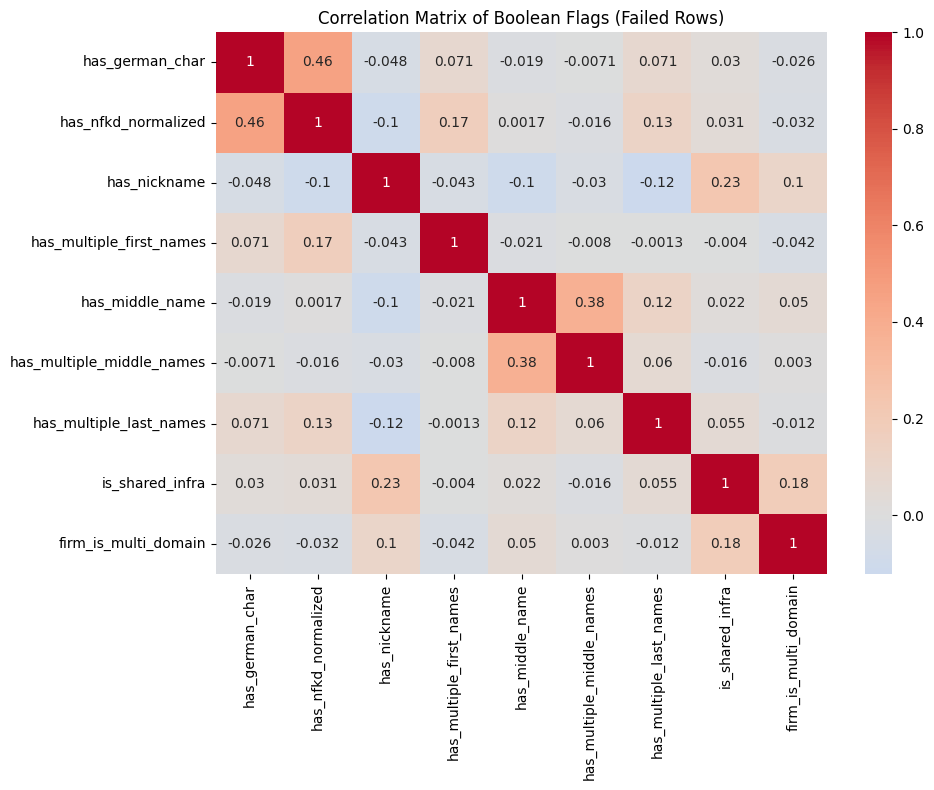

In [8]:
corr = failed_rows[bool_flags].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Boolean Flags (Failed Rows)")
plt.tight_layout()
plt.show()

`has_nickname` and `is_shared_infra` seem to have a surprising correlation in the failing sets. Maybe some sort of proxy for multiple addresses. Other than that nothing really of note in the matrix. `has_german_char` and `has_nfkd_normalized` are expectedly correlated since german chars will show up in the NFKD normalization process. Similar thing going on with `has_middle_name` and `has_multiple_middle_names`.

In [9]:
# Flag if two appear at the same time even once
cooccurrence = failed_rows[bool_flags].T.dot(failed_rows[bool_flags])
print(cooccurrence)

                           has_german_char  has_nfkd_normalized  has_nickname  \
has_german_char                       True                 True          True   
has_nfkd_normalized                   True                 True          True   
has_nickname                          True                 True          True   
has_multiple_first_names              True                 True          True   
has_middle_name                      False                 True          True   
has_multiple_middle_names            False                False          True   
has_multiple_last_names               True                 True          True   
is_shared_infra                       True                 True          True   
firm_is_multi_domain                  True                 True          True   

                           has_multiple_first_names  has_middle_name  \
has_german_char                                True            False   
has_nfkd_normalized                          

A lot of concurrence between these flags, to be expected since complex names tend to have multiple complex flags hit at once.

In [10]:
# Use regression to identify most contributing flags
test_rows = lp_clean[lp_clean["id"].isin(comp_ids + std_ids)]
X = test_rows[bool_flags]
y = test_rows["id"].isin(failed_rows["id"]).astype(int)

# Fit and get coeffs
model = LogisticRegression().fit(X, y)
importance = pd.Series(model.coef_[0], index=bool_flags).sort_values(ascending=False)
print(importance)

has_multiple_last_names      2.002214
has_nfkd_normalized          1.399203
has_middle_name              1.151859
has_multiple_first_names     0.865108
firm_is_multi_domain         0.682386
has_nickname                 0.531075
has_multiple_middle_names   -0.056693
has_german_char             -0.207086
is_shared_infra             -0.376326
dtype: float64


Interesting, `has_multiple_last_names` is a clear signal of failure. Not sure if this is just overrepresented in the edge case templates or if there is something funny about how we resolve or parse multiple last names. Will have to look at the inference engine to get a better look.

`has_nfkd_normalized` is also a clear signal. This could be because the CPP NFKD pipeline is functionally different from the Python version. Will need to generate some test data and try to confirm the CPP implementation. 

`has_middle_name` is also a clear signal, probably do to it only being represented in a few test cases, although it could be a problem with the name parsing in CPP.

In [11]:
failing_firms = failed_rows["firm"].unique()
failing_firm_stats = firm_template_map[firm_template_map["firm"].isin(failing_firms)]

# Sort by template diversity
print(failing_firm_stats[["firm", "num_templates", "num_investors", "diversity_ratio"]]
      .sort_values("diversity_ratio", ascending=False).head(10))

# Distribution of is_single_template
print(failing_firm_stats["is_single_template"].value_counts())

                                                    firm  num_templates  \
14733  university of pennsylvania health and welfare ...              5   
14661        university of california, irvine foundation              3   
2595                             cabot wealth management              2   
12879                                        siemprelara              4   
12616                                      sedco capital              5   
12773  sharp rees-stealy medical group, inc. money pu...              1   
1937                                            belvalor              2   
14302                    trihealth, inc. retirement plan              1   
1307               association of family offices in asia              4   
10012                        new india assurance company              5   

       num_investors  diversity_ratio  
14733              5              1.0  
14661              3              1.0  
2595               2              1.0  
12879         

Ok so clearly template diversity is a signal for failing predictions, although single template firms do not ensure a correct prediction - could be a good sign since it means the model isn't over fitting to the dominate trends.

In [12]:
# Statistics comparison
print("Diversity ratio:", failing_firm_stats["diversity_ratio"].describe())
print("# of templates:", failing_firm_stats["num_templates"].describe())
print("# of investors:", failing_firm_stats["num_investors"].describe())

Diversity ratio: count    329.000000
mean       0.343895
std        0.268869
min        0.005325
25%        0.115385
50%        0.285714
75%        0.500000
max        1.000000
Name: diversity_ratio, dtype: float64
# of templates: count    329.000000
mean       3.978723
std        2.818088
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       21.000000
Name: num_templates, dtype: float64
# of investors: count     329.000000
mean       45.449848
std       126.257207
min         1.000000
25%         5.000000
50%        11.000000
75%        37.000000
max      1399.000000
Name: num_investors, dtype: float64


First thing to note is that the 1200 failing rows are spread across 329 firms, meaning our firm diversity is quite rich.

Also, clearly our failing firms are small and diverse. This is clearly a toss up for the model and of course less diverse firms are much easier to predict for.

In [ ]:
# Compare diversity with all firms
comparison = pd.DataFrame({
    "All Firms": firm_template_map[["diversity_ratio", "num_templates"]].median(),
    "Failing Firms": failing_firm_stats[["diversity_ratio", "num_templates"]].median()
})
print(comparison)

                 All Firms  Failing Firms
diversity_ratio        0.5       0.285714
num_templates          1.0       4.000000


The trends towards diversity are more prevalent in the failing firms.

In [14]:
# Print failing templates
failed_rows["token_str"] = failed_rows["token_seq"].apply(json.dumps)
fail_counts  = failed_rows["token_str"].value_counts()
print(fail_counts.head(10)), fail_counts.shape

token_str
["first_original_0", ".", "last_original_0"]         581
["f_0", "last_original_0"]                           316
["first_original_0", "last_original_0"]               43
["first_original_0", ".", "last_original_surp_0"]     34
["f_0", "last_original_0", "last_original_1"]         25
["first_original_0"]                                  21
["first_original_0", "l_0"]                           18
["first_nickname_0", ".", "last_original_0"]          15
["f_0", "last_original_surp_0"]                       14
["first_nfkd_0", ".", "last_original_0"]              13
Name: count, dtype: int64


/tmp/ipykernel_59221/3737922980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_rows["token_str"] = failed_rows["token_seq"].apply(json.dumps)


(None, (91,))

We can see that a large portion of the failing cases are represented by just a couple templates. The leading two templates are also the most common in the regular dataset so the makes sense in terms of distributions.

In [ ]:
failing_templates = candidate_templates[
    candidate_templates["template"].isin(fail_counts.index)
]
# Add fail_count
failing_templates["fail_count"] = failing_templates["template"].map(fail_counts)

# Compute fail_rate
failing_templates["fail_rate"] = (
    failing_templates["fail_count"] / failing_templates["support_count"]
).fillna(0)

/tmp/ipykernel_59221/1641077649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failing_templates["fail_count"] = failing_templates["template"].map(fail_counts)
/tmp/ipykernel_59221/1641077649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failing_templates["fail_rate"] = (


In [ ]:
print(failing_templates[["support_count", "fail_count", "fail_rate"]].describe())

       support_count  fail_count  fail_rate
count      91.000000   91.000000  91.000000
mean      914.670330   13.714286   0.298179
std      4660.596452   68.800401   0.370132
min         1.000000    1.000000   0.001361
25%         2.500000    1.000000   0.035760
50%        19.000000    1.000000   0.090909
75%        97.500000    3.500000   0.500000
max     31632.000000  581.000000   1.000000


There only 91 templates from the 416 totaled mined featuring in the failed set. Most of them are low support, but some are high support which indicates that high support templates are not guaranteed to pass. Our fail rate is skewed and there is a non trivial amount of templates that fail 100% of the time.

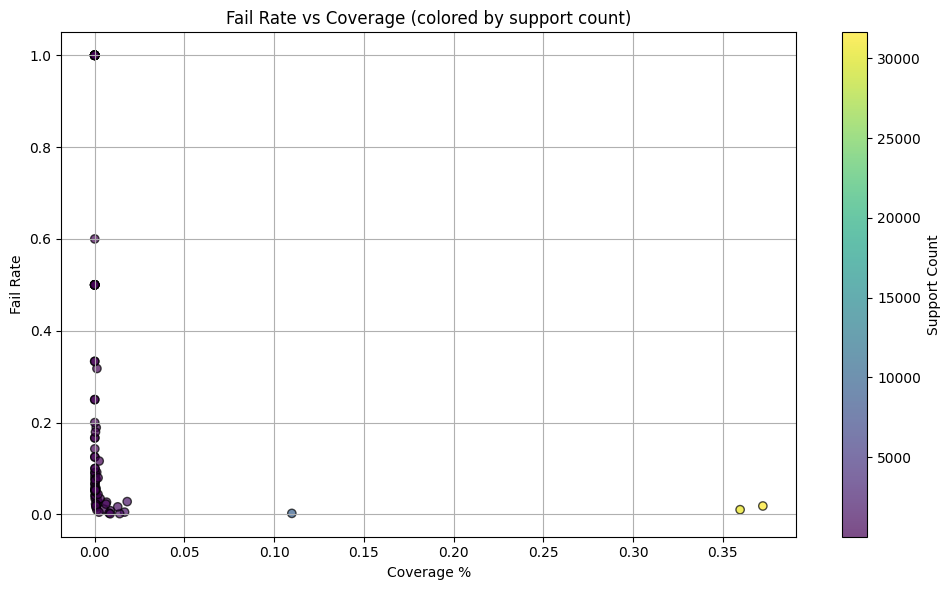

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(
    failing_templates["coverage_pct"],
    failing_templates["fail_rate"],
    alpha=0.7,
    c=failing_templates["support_count"],
    cmap="viridis",
    edgecolor="k"
)
plt.xlabel("Coverage %")
plt.ylabel("Fail Rate")
plt.title("Fail Rate vs Coverage (colored by support count)")
plt.colorbar(label="Support Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Thankfully, our 100% failure templates are extremely low coverage. In fact most of our failing cases are. However, the high coverage templates are not guaranteed but once again this could indicate simply that we are not over fitting. 

## GP Data added in

This round of testing focuses on the GP data addition with the LP. Our template usage has increased with the same disproportion to the complex case.

We will do largely the same analysis focusing on the most telling parts to see if the same holds true. First lets look at our template distribution.

In [3]:
# Read clean data
comb_clean = read_table(TableName.COMBINED_CLEAN)

Read COMBINED_CLEAN table from database!


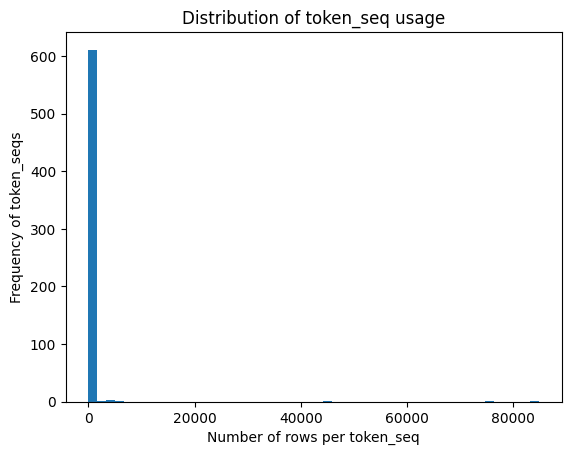

In [14]:
# Count frequency of each token sequence
token_seq_counts = comb_clean["token_seq"].value_counts()

plt.hist(token_seq_counts, bins=50)
plt.xlabel("Number of rows per token_seq")
plt.ylabel("Frequency of token_seqs")
plt.title("Distribution of token_seq usage")
plt.show()

Similar to the single dataset case, once again must investors use only a few templates with the rest being edge cases. 

In [7]:
# Isolate failed rows
failed_rows = comb_clean[comb_clean["id"].isin(failed_ids)]
failed_rows.shape

(2711, 34)

In [15]:
# Boolean flags
bool_flags = [
    "has_german_char", "has_nfkd_normalized", "has_nickname",
    "has_multiple_first_names", "has_middle_name",
    "has_multiple_middle_names", "has_multiple_last_names",
    "is_shared_infra", "firm_is_multi_domain"
]

# Get non failed ids
comp_ids = pd.read_csv("../../cpp_inference_engine/tests/test_data/test_comp_ids.csv")["test_ids"].to_list()
std_ids = pd.read_csv("../../cpp_inference_engine/tests/test_data/test_std_ids.csv")["test_ids"].to_list()
passed_ids = [x for x in comp_ids + std_ids if x not in failed_ids]

non_failed_rows = comb_clean[comb_clean["id"].isin(passed_ids)]

# Compare from passing distributions.
compare_flags = pd.DataFrame({
    "fail_pct": failed_rows[bool_flags].mean(),
    "non_fail_pct": non_failed_rows[bool_flags].mean()
}).sort_values("fail_pct", ascending=False)

compare_flags["difference"] = compare_flags["fail_pct"] - compare_flags["non_fail_pct"]
print(compare_flags)

                           fail_pct  non_fail_pct  difference
is_shared_infra            0.454814      0.282198    0.172616
firm_is_multi_domain       0.236075      0.256953   -0.020878
has_nickname               0.190336      0.218217   -0.027882
has_multiple_last_names    0.140170      0.009599    0.130570
has_nfkd_normalized        0.101070      0.012215    0.088855
has_middle_name            0.064183      0.008123    0.056060
has_multiple_first_names   0.058650      0.003184    0.055466
has_german_char            0.024345      0.004031    0.020315
has_multiple_middle_names  0.006271      0.000631    0.005640


Largely the same as the previous case. If anything, the GP dataset amplifies the effect on failure probably due to the increase in edge case templates that the GP set introduces. Interestingly, `is_shared_infra` and `firm_is_multi_domain` have flipped there difference sign, indicating that their effect changes with the introduction of the GP dataset. Possibly something to do with GP investors higher seniority and the autonomy to use different domains or infrastructure.

In [10]:
# Use regression to identify most contributing flags
test_rows = comb_clean[comb_clean["id"].isin(comp_ids + std_ids)]
X = test_rows[bool_flags]
y = test_rows["id"].isin(failed_rows["id"]).astype(int)

# Fit and get coeffs
model = LogisticRegression().fit(X, y)
importance = pd.Series(model.coef_[0], index=bool_flags).sort_values(ascending=False)
print(importance)

has_multiple_first_names     2.933601
has_multiple_last_names      2.694709
has_nfkd_normalized          1.744457
has_middle_name              1.707807
is_shared_infra              0.801662
has_multiple_middle_names    0.167905
has_german_char             -0.030795
has_nickname                -0.043392
firm_is_multi_domain        -0.233584
dtype: float64


Similar story here. We are seeing a large amplification in some fields with the introduction of noisier data.

In [11]:
failing_firms = failed_rows["firm"].unique()
failing_firm_stats = firm_template_map[firm_template_map["firm"].isin(failing_firms)]

# Statistics comparison
print("Diversity ratio:", failing_firm_stats["diversity_ratio"].describe())
print("# of templates:", failing_firm_stats["num_templates"].describe())
print("# of investors:", failing_firm_stats["num_investors"].describe())
# Compare diversity with all firms
comparison = pd.DataFrame({
    "All Firms": firm_template_map[["diversity_ratio", "num_templates"]].median(),
    "Failing Firms": failing_firm_stats[["diversity_ratio", "num_templates"]].median()
})
print(comparison)

Diversity ratio: count    1223.000000
mean        0.318980
std         0.253646
min         0.005000
25%         0.125000
50%         0.250000
75%         0.500000
max         1.000000
Name: diversity_ratio, dtype: float64
# of templates: count    1223.000000
mean        3.390842
std         2.512355
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        20.000000
Name: num_templates, dtype: float64
# of investors: count    1223.000000
mean       32.998365
std        83.850365
min         1.000000
25%         5.000000
50%        11.000000
75%        28.000000
max      1396.000000
Name: num_investors, dtype: float64
                 All Firms  Failing Firms
diversity_ratio        0.5           0.25
num_templates          1.0           3.00


Template diversity are still strong signal of failure in this combined set - although the LP data is more diverse in failing cases.

In [12]:
failed_rows["token_str"] = failed_rows["token_seq"].apply(json.dumps)
fail_counts  = failed_rows["token_str"].value_counts()
failing_templates = candidate_templates[
    candidate_templates["template"].isin(fail_counts.index)
]
# Add fail_count
failing_templates["fail_count"] = failing_templates["template"].map(fail_counts)

# Compute fail_rate
failing_templates["fail_rate"] = (
    failing_templates["fail_count"] / failing_templates["support_count"]
).fillna(0)
print(failing_templates[["support_count", "fail_count", "fail_rate"]].describe())

       support_count  fail_count   fail_rate
count     215.000000  215.000000  215.000000
mean     1124.060465   12.609302    0.305576
std      8311.292269   65.859493    0.318220
min         1.000000    1.000000    0.000882
25%         3.000000    1.000000    0.076923
50%         9.000000    1.000000    0.185185
75%        57.500000    3.000000    0.500000
max     84892.000000  755.000000    1.000000


/tmp/ipykernel_22846/566984162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_rows["token_str"] = failed_rows["token_seq"].apply(json.dumps)
/tmp/ipykernel_22846/566984162.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failing_templates["fail_count"] = failing_templates["template"].map(fail_counts)
/tmp/ipykernel_22846/566984162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

We have higher median failure rates in the combined set. The GP dataset introduces many templates with very large support counts, but also some that fail more often. Seems like this data introduces frequent but harder to predict templates.

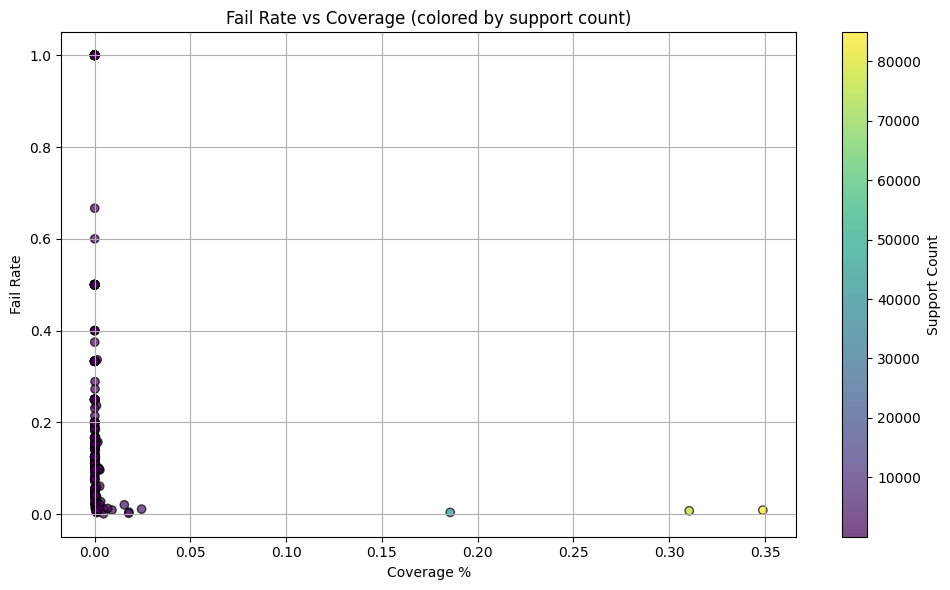

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(
    failing_templates["coverage_pct"],
    failing_templates["fail_rate"],
    alpha=0.7,
    c=failing_templates["support_count"],
    cmap="viridis",
    edgecolor="k"
)
plt.xlabel("Coverage %")
plt.ylabel("Fail Rate")
plt.title("Fail Rate vs Coverage (colored by support count)")
plt.colorbar(label="Support Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Very similar story being told here in the GP combined dataset. Lets look at the support counts for failing complex names.

In [28]:
# Define complex name condition
complex_mask = (
    failed_rows["has_multiple_first_names"] |
    failed_rows["has_multiple_last_names"] |
    failed_rows["has_nfkd_normalized"] |
    failed_rows["has_middle_name"] |
    failed_rows["has_multiple_middle_names"]
)

# Filter
complex_fails = failed_rows[complex_mask]

# Match format in failing templates
failing_templates["token_seq"] = failing_templates["template"].apply(json.loads)

# Get all token_seq values from complex_fails
complex_token_seqs = complex_fails["token_seq"].to_list()

# Filter failing_templates to only those matching complex_fails' token_seq
complex_failing_templates = failing_templates[
    failing_templates["token_seq"].isin(complex_token_seqs)
]
complex_failing_templates["support_count"].describe()

/tmp/ipykernel_22846/4143779658.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failing_templates["token_seq"] = failing_templates["template"].apply(json.loads)


count      194.000000
mean      1191.932990
std       8743.647438
min          1.000000
25%          2.000000
50%          7.000000
75%         44.750000
max      84892.000000
Name: support_count, dtype: float64

So we have a skewed distribution again. Some templates are extremely common, hinting at the fact that some complex investors use standard templates despite there complex names. 

Would be interesting to see which complex name flags are used for high support templates.

In [45]:
def get_x_support_failing_templates(x):
    # High-support subset
    high_support_complex = complex_failing_templates[
        complex_failing_templates["support_count"] >= x
    ]
    high_support_cases = (
        high_support_complex
        .sort_values("support_count", ascending=False)[["token_seq", "support_count"]]
    )
    high_support_token_seqs = high_support_cases["token_seq"]
    print(high_support_cases)
    return high_support_token_seqs

In [46]:
high_support_token_seqs = get_x_support_failing_templates(100)

                                             token_seq  support_count
502                             [f_0, last_original_0]          84892
370             [first_original_0, ., last_original_0]          75540
428                                 [first_original_0]          45167
264                                  [last_original_0]           5958
244                                         [f_0, l_0]           4353
284                          [f_0, ., last_original_0]           4320
359                             [last_original_0, f_0]           1137
200                 [first_original_0, ., last_nfkd_0]            770
24             [f_0, last_original_0, last_original_1]            663
332                 [first_nfkd_0, ., last_original_0]            640
460  [first_original_0, ., last_original_0, -, last...            589
424  [first_original_0, ., last_original_0, last_or...            568
145                                 [f_0, last_nfkd_0]            454
89   [first_original

Ok so the vast majority of these are standard templates, with the exception of some normalization here and there. Aside from that there is some multiple first name and last name going on, some middle names. All largely low support in the face of the ~24000 rows in the combined clean set.

In [44]:
# Filter by support
complex_fails_high_support = complex_fails[
    complex_fails["token_seq"].isin(high_support_token_seqs)
]

# Inspect flag columns
flag_cols = [
    "has_multiple_first_names",
    "has_multiple_last_names",
    "has_nfkd_normalized",
    "has_middle_name",
    "has_multiple_middle_names",
    "has_german_char",
    "has_nickname",
]
flag_summary = complex_fails_high_support[flag_cols].mean().sort_values(ascending=False)
print(flag_summary)

has_multiple_last_names      0.472693
has_nfkd_normalized          0.278719
has_multiple_first_names     0.190207
has_middle_name              0.131827
has_nickname                 0.129944
has_german_char              0.050847
has_multiple_middle_names    0.005650
dtype: float64


Ok so the main culprits here are multiple first and last names. Also unicode normalization stuff is interfering. Its been said before but normalization like this should be done as standard and i believe these tokens should be removed. This may cause some resolution issues but i think we will be better off doing this rather than including impossible to predict tokens that distract from the actual sequence we are trying to predict.

Lets do the same but with truly high support templates.

In [47]:
high_support_token_seqs = get_x_support_failing_templates(10000)

# Filter by support
complex_fails_high_support = complex_fails[
    complex_fails["token_seq"].isin(high_support_token_seqs)
]

# Inspect flag columns
flag_cols = [
    "has_multiple_first_names",
    "has_multiple_last_names",
    "has_nfkd_normalized",
    "has_middle_name",
    "has_multiple_middle_names",
    "has_german_char",
    "has_nickname",
]
flag_summary = complex_fails_high_support[flag_cols].mean().sort_values(ascending=False)
print(flag_summary)

                                  token_seq  support_count
502                  [f_0, last_original_0]          84892
370  [first_original_0, ., last_original_0]          75540
428                      [first_original_0]          45167
has_multiple_last_names      0.775862
has_middle_name              0.172414
has_nickname                 0.137931
has_nfkd_normalized          0.120690
has_german_char              0.068966
has_multiple_first_names     0.017241
has_multiple_middle_names    0.000000
dtype: float64


Multiple last names is the main disruptor here. Clearly the model is inferring that the presence of multiple last names should result in a more complex template. This highlights the struggle of the complex model and the difficulty it has picking from more templates and less data than the standard model.

# Pruned Token List

90% Acc@1 in test with 96% Recall@3. Real gains here are in the Complex case which has performed much better in validation.

In [72]:
# Load data from SQL
comb_clean = read_table(TableName.COMBINED_CLEAN)
firm_template_map = read_table(TableName.FIRM_TEMPLATE_MAP)
candidate_templates = read_table(TableName.CANDIDATE_TEMPLATES)

# Load failing ids pulled from integration tests
failed_ids = pd.read_csv("failed_ids_catboost.csv")["failed_ids"].to_list()
failed = comb_clean[comb_clean["id"].isin(failed_ids)]

# Load all test ids 
comp_ids = pd.read_csv("../../cpp_inference_engine/tests/test_data/test_comp_ids.csv")["test_ids"].to_list()
std_ids = pd.read_csv("../../cpp_inference_engine/tests/test_data/test_std_ids.csv")["test_ids"].to_list()
passed_ids = [x for x in comp_ids + std_ids if x not in failed_ids]
non_failed_rows = comb_clean[comb_clean["id"].isin(passed_ids)]


Read COMBINED_CLEAN table from database!
Read FIRM_TEMPLATE_MAP table from database!
Read CANDIDATE_TEMPLATES table from database!


In [81]:
# See distributions of flags in failing cases
cols = [
    "is_shared_infra",
    "firm_is_multi_domain",
    "has_german_char",
    "has_nfkd_normalized",
    "has_nickname",
    "has_multiple_first_names",
    "has_middle_name",
    "has_multiple_middle_names",
    "has_multiple_last_names",
]

failed_dist = failed[cols].mean().sort_values(ascending=False)
print(failed_dist)

is_shared_infra              0.451680
firm_is_multi_domain         0.205724
has_nickname                 0.197014
has_nfkd_normalized          0.125674
has_multiple_last_names      0.124844
has_german_char              0.062215
has_middle_name              0.048113
has_multiple_first_names     0.029448
has_multiple_middle_names    0.005392
dtype: float64


Shared architecture flags are still the strongest signal of failure here. Nicknames are also a problem, largely because the CPP inference is not designed to handle this.

In [82]:
# Distributions for failing and non-failing rows
failed_dist = failed[cols].mean()
non_failed_dist = non_failed_rows[cols].mean()

comparison = pd.DataFrame({
    "failed": failed_dist,
    "non_failed": non_failed_dist,
})
comparison["lift"] = comparison["failed"] / comparison["non_failed"]

print(comparison.sort_values("lift", ascending=False))

                             failed  non_failed       lift
has_german_char            0.062215    0.004042  15.391493
has_multiple_last_names    0.124844    0.013579   9.194168
has_nfkd_normalized        0.125674    0.014731   8.531016
has_multiple_middle_names  0.005392    0.000778   6.926172
has_multiple_first_names   0.029448    0.005060   5.819624
has_middle_name            0.048113    0.010315   4.664359
is_shared_infra            0.451680    0.287053   1.573506
has_nickname               0.197014    0.215567   0.913933
firm_is_multi_domain       0.205724    0.256917   0.800741


Transliteration has popped its head out, and become prevalent in the failing cases - probably since we are now treating this as default normalization which means cases where tranliterable characters exist in the name but not transliterated (instead just NFKDed) are now failing. Similar story to the NFKD case. Other than than that nothing that we haven't seen before. It would be interesting to once again look at failing templates and their supports.

In [83]:
failed["token_str"] = failed["token_seq"].apply(json.dumps)
fail_counts  = failed["token_str"].value_counts()
failing_templates = candidate_templates[
    candidate_templates["template"].isin(fail_counts.index)
]
print(failing_templates.describe())

# Check to see how many are one support
one_support = failing_templates[failing_templates["support_count"] == 1]
print("Count:", len(one_support))
print("Fraction:", len(one_support) / len(failing_templates))

       template_id  support_count  coverage_pct  max_rule_confidence  \
count   119.000000     119.000000    119.000000           119.000000   
mean    227.739496    2020.840336      0.008328             0.399329   
std     121.080409   11263.101776      0.046413             0.441662   
min       3.000000       1.000000      0.000004             0.000000   
25%     125.500000       4.000000      0.000016             0.000000   
50%     223.000000      13.000000      0.000054             0.052153   
75%     329.000000     119.500000      0.000492             0.924233   
max     442.000000   85374.000000      0.351811             0.983181   

       avg_rule_confidence  
count           119.000000  
mean              0.295249  
std               0.336774  
min               0.000000  
25%               0.000000  
50%               0.052153  
75%               0.618773  
max               0.924233  
Count: 9
Fraction: 0.07563025210084033


/tmp/ipykernel_1750596/575653555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed["token_str"] = failed["token_seq"].apply(json.dumps)


Similar support stats to what weve seen. It seems like the actual one support investors are by far the minority in failing cases. Would be intresting to see what the predictor actually predicted to see what their supports are.

In [84]:
# Load the CSV
df = pd.read_csv("failed_template_catboost.csv")
# Get unique failed ids (ignoring 0s)  - clashing templates to investors are marked 0 in CPP inference
fail_ids = df.loc[df["failed_templates"] != 0, "failed_templates"].unique()
# Pull metadata for those failed ids
failed_templates = candidate_templates[
    candidate_templates["template_id"].isin(fail_ids)
][["template_id", "support_count", "coverage_pct", "template"]]

# Sort by support_count to see which failing templates are well/poorly supported
failed_templates = failed_templates.sort_values("support_count", ascending=False)
failed_templates

,template_id,support_count,coverage_pct,template
198,199,85374,0.351811,"[""f_0"", ""last_original_0""]"
411,412,77467,0.319228,"[""first_original_0"", ""."", ""last_original_0""]"
170,171,45424,0.187184,"[""first_original_0""]"
284,285,6049,0.024927,"[""last_original_0""]"
416,417,4353,0.017938,"[""f_0"", ""l_0""]"
325,326,3792,0.015626,"[""first_original_0"", ""last_original_0""]"
245,246,1656,0.006824,"[""last_original_0"", ""first_original_0""]"
238,239,1146,0.004722,"[""first_original_0"", ""_"", ""last_original_0""]"
278,279,1143,0.004710,"[""last_original_0"", ""f_0""]"
331,332,686,0.002827,"[""f_0"", ""last_original_0"", ""last_original_1""]"


A lot of low support templates being chosen here. I wonder how many times the predictor predicts a low support template, since there are only a few failed templates and couple thousand failed cases. Also this a unique list and doesnt take into account how often a one of these templates is chosen when it shouldn't.

In [85]:
# Load failing template ids (excluding 0)
pred_ids  = pd.read_csv("failed_template_catboost.csv")
fails = pred_ids [pred_ids ["failed_templates"] != 0]


# Join failures with their metadata
failed_meta = fails.merge(candidate_templates[["template_id", "support_count"]],
                            left_on="failed_templates",
                            right_on="template_id",
                            how="left"
)
pred_ids = pred_ids["failed_templates"]

# Count how many failures are from templates with support < 3
low_support_fails = (failed_meta["support_count"] < 3).sum()
total_fails = len(failed_meta)
low_support_fails, total_fails, low_support_fails/total_fails

(np.int64(1335), 2135, np.float64(0.6252927400468384))

So ultra rare templates are the majority of our miss-predictions here. It would be interesting to see how often a low support template is chosen in place of high support one.

In [98]:
fails = pd.DataFrame({
    "id": failed_ids,              # true row ids (clean data)
    "pred_id": pred_ids.values  # predicted template_id
})

# Pull token_seq for those ids, keep row order
fails = fails.merge(
    comb_clean[["id", "token_seq"]],
    on="id", how="left"
)
fails["token_str"] = fails["token_seq"].apply(json.dumps)

# Attach TRUE support
fails = fails.merge(
    candidate_templates[["template", "support_count"]]
        .rename(columns={"support_count": "true_support"}),
    left_on="token_str", right_on="template",
    how="left"
).drop(columns=["template"])

# Map PRED support via template_id -> candidate_templates
fails = fails.merge(
    candidate_templates[["template_id", "support_count"]]
        .rename(columns={"support_count": "pred_support"}),
    left_on="pred_id", right_on="template_id",
    how="left"
).drop(columns=["template_id"])

# low pred vs high true 
true_high = fails["true_support"] >= 50000
pred_low  = fails["pred_support"] < 2

mask = true_high & pred_low

count = mask.sum()
total = len(fails)
print(f"Pred low support while true high support: {count} / {total} ({count/total:.2%})")

Pred low support while true high support: 1058 / 2597 (40.74%)


In [99]:
len(candidate_templates[candidate_templates["support_count"] < 2])

183

Ok so clearly our model is suffering from a diluted template list. Removing the 1 support templates means we will lose out on at most 183 predictions but we could potentially of gained that back from correctly predicting any of the 1058 failing cases that selected one of those low support templates. Not only that, but of 444 templates we would almost half our template diversity by removing the ultra rare cases, making the models jobs of ranking much easier.